# Benchmarking Julia on a PDE: the Kuramoto-Sivashinksy equation

John F. Gibson, Department of Mathematics and Statistics, University of New Hampshire<br>
Last update 2019-10-30 using Julia-1.2.0.

## The benchmark algorithm: KS-CNAB2

The Kuramoto-Sivashinsky (KS) equation is a nonlinear time-evolving partial differential equation (PDE) on a 1d spatial domain.

\begin{equation*}
u_t = -u u_{x} - u_{xx} - u_{xxxx}
\end{equation*}

where $x$ is space, $t$ is time, and subscripts indicate differentiation. We assume a spatial domain $x \in [0, L_x]$ with periodic boundary conditions.

The KS-CNAB2 benchmark algorithm is a simple numerical integration scheme for the KS equation that uses Fourier expansion in space, collocation calculation of the nonlinear term $u u_x$, and finite-differencing in time, specifically 2nd-order Crank-Nicolson Adams-Bashforth (CNAB2) timestepping. Mathematical details of KS-CNAB2 algorithm are provided [below](#Mathematics-of-the-CNAB2-algorithm).

As PDE solvers go, this one is super-simple, about twenty lines of code, and so comparable in scale to the Fibonnaci, pi-sum, etc. benchmarks at https://julialang.org/benchmarks/.
However this benchmark is a little different from those in that the dominant cost of the algorithm should be the fast Fourier transforms (FFTs), which in all languages are performed with calls to the same external C library, [FFTW](http://fftw.org/). So what I'm testing here is the overhead each language imposes over FFTW for things like function calls, index bounds checking, allocation of temporary arrays, and pointer dereferencing. 

This benchmark is meant as a preliminary investigation towards using Julia for classic high-performance computations (HPC) for PDEs from engineering and physics.|


## Results: 

### Execution time versus simulation size


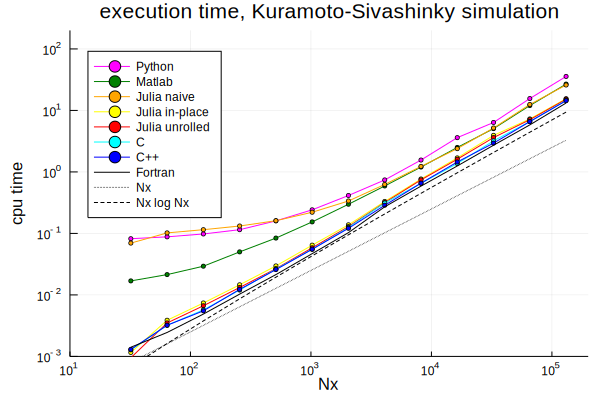

In [8]:
using Plots
using DelimitedFiles
gr()

d = readdlm("benchmark-data/cputime.asc", comments=true)

Nx = d[:,1]
plot(Nx,  d[:,7],  label="Python", marker=:circ, markersize=2, color="magenta")
plot!(Nx, d[:,5],  label="Matlab", marker=:circ, markersize=2, color="green")
plot!(Nx, d[:,9],  label="Julia naive", marker=:circ, markersize=2, color="orange")
plot!(Nx, d[:,10], label="Julia in-place", marker=:circ, markersize=2, color="yellow")
plot!(Nx, d[:,11], label="Julia unrolled", marker=:circ, markersize=2, color="red")
plot!(Nx, d[:,3],  label="C", marker=:circ, markersize=2, color="cyan")
plot!(Nx, d[:,4],  label="C++", marker=:circ, markersize=2, color="blue")
plot!(Nx, d[:,2],  label="Fortran", linestyle=:solid, color="black")
plot!(Nx, 2.5e-05*Nx, label="Nx", linestyle=:dot, color="black")
plot!(Nx, 1.4e-05*Nx .* log10.(Nx), label="Nx log Nx", linestyle=:dash, color="black")
plot!(xlabel="Nx", ylabel="cpu time", title="execution time, Kuramoto-Sivashinky simulation")
plot!(yscale=:log10, xscale=:log10,xlim=(10,2e05),ylim=(1e-03,2e02), legend=:topleft)

**Comments:**

**Julia unrolled and Fortran results are practically identical.** Look closely for the black line (Fortran) passing through red dots (Julia unrolled).

**Expectation of $N_x \log N_X$ scaling**. Execution time for this algorithm should ideally be dominated by the $N_x \log N_x$ cost of the FFTs. In the above plot, all the codes do appear to scale as $N_x \log N_x$ at large $N_x$ with different prefactors. However it's hard to understand why there would be different prefactors for the FFT cost when all they're all calls to the same FFTW C library. Perhaps linear-cost language differences are actually dominating the FFTs. See the linear-linear plot below.

**Different Julia implementation:** I wrote three different Julia codes using three different levels of Julia knowledge. 

   * **Julia naive** is a straight translation of a Matlab code, all vectorized and paying no attention to allocation of temporary arrays inside the time-stepping loop. 
  
   * **Julia in-place** eliminates temporaries and allocations by using in-place FFTs and julia-0.6's loop fusion capability.
  
   * **Julia unrolled** uses in-place FFTs and unrolls all the vector time-stepping operations into explicit for loops. 
  
**Who beats whom?** Julia naive beats Python by a factor of 1.38 and is slightly better than Matab. Julia in-place and Julia unrolled are close to C and (factors of 1.06 and 1.04), and Julia unrolled is close to C (factor of 1.04). Execution times of Julia in-place, Julia unrolled, C, C++, and Fortran are all pretty close, about a 15% spread. The benchmarks were averaged over thousands of runs for $N_x = 32$ scaling down to 8 runs for $N_x = 2^{17}$; even so the timing averages varied a few percent. 

**CPU, OS, and compiler:** All benchmarks were run single-threaded on a six-core Intel Core i7-3960X CPU @ 3.30GHz with 64 GB memory running openSUSE Leap 42.2. C and C++ were compiled with clang 3.8.0, Fortran with gfortran 4.8.3, Julia was julia-1.2.0 (downloaded from [julialang.org](http://www.julialang.org)), and all used optimization ``-O3``. For more details see [benchmark-data/cputime.asc](benchmark-data/cputime.asc). 


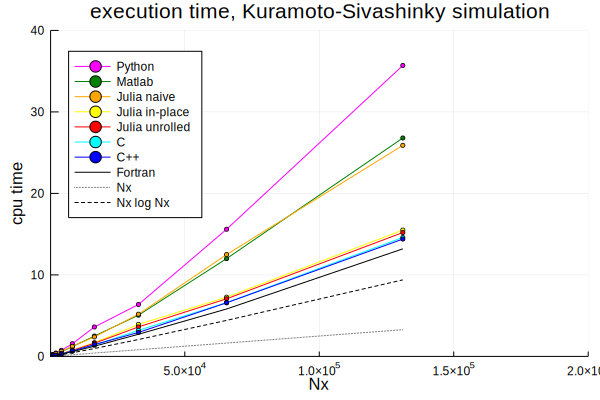

In [9]:
plot!(xlim=(1e02,2e05), ylim=(0,40), yscale=:linear, xscale=:linear)

Timings for the last datapoint, $N_x = 2^{17} = 131072$. Cputime is in seconds. The last column shows cputime normalized so that C = 1. 

language | cputime | ratio to C  
---------|---------|------
Python         | 35.7 | 2.45 
Matlab         | 26.8 | 1.83
Julia naive    | 25.9 | 1.77
Julia in-place | 15.5 | 1.06
Julia unrolled | 15.2 | 1.04 
C              | 14.6 | 1.00
C++            | 14.4 | 0.99
Fortran        | 13.0 | 0.90 

### Execution time versus lines of code

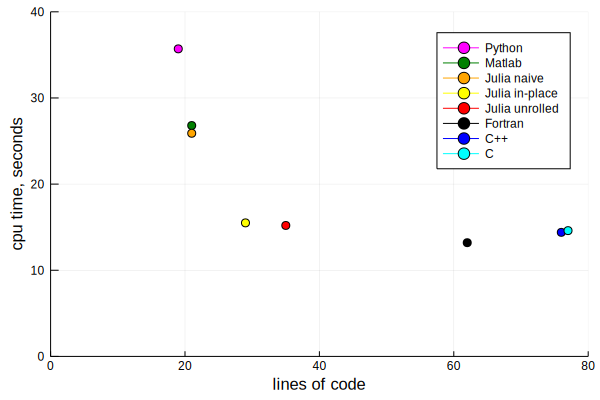

In [11]:
d = readdlm("benchmark-data/linecount.asc",comments=true)
Nx = d[:,1]
plot([d[1,2]], [d[1,1]],  label="Python", marker=:circ, color="magenta")
plot!([d[2,2]], [d[2,1]], label="Matlab", marker=:circ, color="green" )
plot!([d[3,2]], [d[3,1]], label="Julia naive", marker=:circ, color="orange")
plot!([d[4,2]], [d[4,1]], label="Julia in-place", marker=:circ, color="yellow")
plot!([d[5,2]], [d[5,1]], label="Julia unrolled", marker=:circ, color="red")
plot!([d[6,2]], [d[6,1]], label="Fortran", marker=:circ, color="black")
plot!([d[7,2]], [d[7,1]], label="C++", marker=:circ, color="blue")
plot!([d[8,2]], [d[8,1]], label="C", marker=:circ, color="cyan")
plot!(xlabel="lines of code", ylabel="cpu time, seconds", xlim=(0,80), ylim=(0,40))

**Comments**

Julia in-place and Julia unrolled clearly hit the sweet spot of low execution time and low line count. 

I included the ``KS module`` definition in the linecount for the Fortran ``ksintegrate`` function, since the module serves as part of the function interface.  

### Ratio of execution speed to linecount

Define execution speed as 1/cputime, so speed/linecount = 1/(cputime\*linecount). Normalize so C = 1.

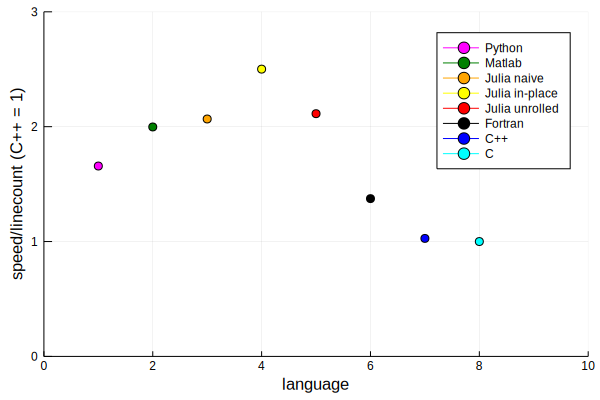

In [12]:
c = d[8,2]*d[8,1] # normalization constant making C = 1
plot([1], [c/(d[1,2]*d[1,1])],  label="Python", marker=:circ, color="magenta")
plot!([2], [c/(d[2,2]*d[2,1])], label="Matlab", marker=:circ, color="green" )
plot!([3], [c/(d[3,2]*d[3,1])], label="Julia naive", marker=:circ, color="orange")
plot!([4], [c/(d[4,2]*d[4,1])], label="Julia in-place", marker=:circ, color="yellow")
plot!([5], [c/(d[5,2]*d[5,1])], label="Julia unrolled", marker=:circ, color="red")
plot!([6], [c/(d[6,2]*d[6,1])], label="Fortran", marker=:circ, color="black")
plot!([7], [c/(d[7,2]*d[7,1])], label="C++", marker=:circ, color="blue")
plot!([8], [c/(d[8,2]*d[8,1])], label="C", marker=:circ, color="cyan")
plot!(xlabel="language", ylabel="speed/linecount (C++ = 1)",ylim=(0,3), xlim=(0,10))

**Comments**

Julia in-place is the winner in the speed/linecount metric. 

## Mathematics of the CNAB2 algorithm

Start from the Kuramoto-Sivashinsky equation $[0,L]$ with periodic boundary conditions

\begin{equation*}
u_t = - u_{xx} - u_{xxxx} - u u_{x}
\end{equation*}

on the domain $[0,L_x]$ with periodic boundary conditions and initial condition $u(x,0) = u_0(x)$. We will use a finite Fourier expansion to discretize space and finite-differencing to discretize time, specifically the 2nd-order rank-Nicolson/Adams-Bashforth (CNAB2) timestepping formula. CNAB2 is low-order but straightforward to describe and easy to implement for this simple benchmark.

Write the KS equation as 

\begin{equation*}
u_t = Lu + N(u)
\end{equation*}

where $Lu = - u_{xx} - u_{xxxx}$ is the linear terms and $N(u) = -u u_{x}$ is the nonlinear term. In practice we'll calculate the $N(u)$ in the equivalent form $N(u) = - 1/2 \, d/dx \, u^2$. 

Discretize time by letting $u^n(x) = u(x, n\Delta t)$ for some small $\Delta t$. The CNAB2 timestepping forumale approximates  $u_t = Lu + N(u)$ at time $t = (n+1/2) \, dt$ as 

\begin{equation*}
\frac{u^{n+1} - u^n}{\Delta t} = L\left(u^{n+1} + u^n\right) + \frac{3}{2} N(u^n) - \frac{1}{2} N(u^{n-1})
\end{equation*}


Put the unknown future $u^{n+1}$'s on the left-hand side of the equation and the present $u^{n}$ and past $u^{n+1}$ on the right.

\begin{equation*}
\left(I  - \frac{\Delta t}{2} L \right) u^{n+1} = \left(I  + \frac{\Delta t}{2}L \right) u^{n} + \frac{3 \Delta t}{2} N(u^n) - \frac{\Delta t}{2} N(u^{n-1})
\end{equation*}
Note that the linear operator $L$ applies to the unknown $u^{n+1}$ on the LHS, but that the nonlinear operator $N$ applies only to the knowns $u^n$ and $u^{n-1}$ on the RHS. This is an *implicit* treatment of the linear terms, which keeps the algorithm stable for large time steps, and an *explicit* treament of the nonlinear term, which makes the timestepping equation linear in the unknown $u^{n+1}$.

Now we discretize space with a finite Fourier expansion, so that $u$ now represents a vector of Fourier coefficients and $L$ turns into matrix (and a diagonal matrix, since Fourier modes are eigenfunctions of the linear operator). Let matrix $A = (I  - \Delta t/2 \; L)$, matrix $B =  (I  + \Delta t/2 \; L)$, and let vector $N^n$ be the Fourier transform of a collocation calculation of $N(u^n)$. That is, $N^n$ is the Fourier transform of $- u u_x = - 1/2 \, d/dx \, u^2$ calculated at $N_x$ uniformly spaced gridpoints on the domain $[0, L_x]$. 

With the spatial discretization, then the CNAB2 timestepping formula becomes 

\begin{equation*}
A \, u^{n+1} = B \, u^n + \frac{3 \Delta t}{2} N^n -  \frac{\Delta t}{2}N^{n-1}
\end{equation*}

This is a simple $Ax=b$ linear algebra problem whose iteration approximates the time-evolution of the Kuramoto-Sivashinksy PDE. 

## Julia implementations of CNAB2 algorithm

### Julia naive

The naive Julia code is pretty much a line-by-line translation of the same thing in Matlab, about 30 lines of code excluding comments and whitespace. Here's a slight modification of the benchmarked algorithm which saves and plots $u(x,t)$ data.

In [13]:
using FFTW 

function ksintegrateNaive(u, Lx, dt, Nt, nsave)
    
    Nx = length(u)                  # number of gridpoints
    x = collect(0:(Nx-1)/Nx)*Lx
    kx = vcat(0:Nx/2-1, 0, -Nx/2+1:-1)  # integer wavenumbers: exp(2*pi*kx*x/L)
    alpha = 2*pi*kx/Lx              # real wavenumbers:    exp(alpha*x)
    D = 1im*alpha;                  # D = d/dx operator in Fourier space
    L = alpha.^2 - alpha.^4         # linear operator -D^2 - D^4 in Fourier space
    G = -0.5*D                      # -1/2 D operator in Fourier space
    
    Nsave = div(Nt, nsave)+1        # number of saved time steps, including t=0
    t = (0:Nsave)*(dt*nsave)        # t timesteps
    U = zeros(Nsave, Nx)            # matrix of u(xⱼ, tᵢ) values
    U[1,:] = u                      # assign initial condition to U
    s = 2                           # counter for saved data
    
    # Express PDE as u_t = Lu + N(u), L is linear part, N nonlinear part.
    # Then Crank-Nicolson Adams-Bashforth discretization is 
    # 
    # (I - dt/2 L) u^{n+1} = (I + dt/2 L) u^n + 3dt/2 N^n - dt/2 N^{n-1}
    #
    # let A = (I - dt/2 L) 
    #     B = (I + dt/2 L), then the CNAB timestep formula is
    # 
    # u^{n+1} = A^{-1} (B u^n + 3dt/2 N^n - dt/2 N^{n-1}) 

    # convenience variables
    dt2  = dt/2
    dt32 = 3*dt/2;
    A_inv = (ones(Nx) - dt2*L).^(-1)
    B     =  ones(Nx) + dt2*L

    Nn  = G.*fft(u.*u) # -u u_x (spectral), notation Nn = N^n     = N(u(n dt))
    Nn1 = copy(Nn)     #                   notation Nn1 = N^{n-1} = N(u((n-1) dt))
    u  = fft(u)        # transform u to spectral

    # timestepping loop
    for n = 1:Nt
        Nn1 = copy(Nn)                 # shift nonlinear term in time: N^{n-1} <- N^n
        Nn  = G.*fft(real(ifft(u)).^2) # compute Nn = -u u_x

        u = A_inv .* (B .* u + dt32*Nn - dt2*Nn1)
        
        if mod(n, nsave) == 0
            U[s,:] = real(ifft(u))
            s += 1            
        end
    end

    t,U
end

ksintegrateNaive (generic function with 1 method)

### Run the Julia code and plot results

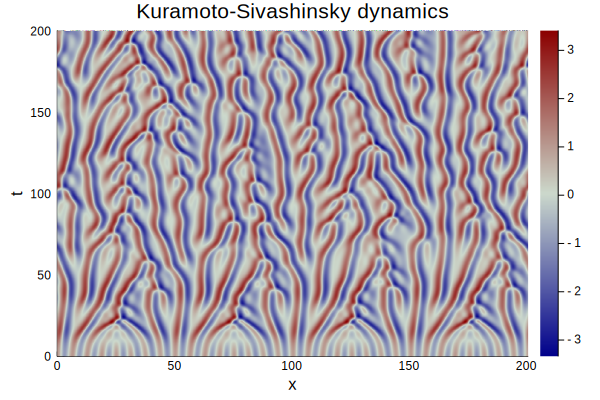

In [14]:
Lx = 64*pi
Nx = 1024
dt = 1/16
nsave = 8
Nt = 3200

x = Lx*(0:Nx-1)/Nx
u = cos.(x) + 0.1*sin.(x/8) + 0.01*cos.((2*pi/Lx)*x);
t,U = ksintegrateNaive(u, Lx, dt, Nt, nsave)

heatmap(x,t,U, xlim=(x[1], x[end]), ylim=(t[1], t[end]), fillcolor=:bluesreds)
plot!(xlabel="x", ylabel="t", title="Kuramoto-Sivashinsky dynamics")

### Julia in-place

The naive Julia code (straight Matlab translation) is slightly slower than Matlab. Can tune the Julia code by 
  * doing FFTs in-place 
  * removing temporary vectors in time-stepping loop
  
These very simple improvements get the Julia performance slightly faster than C++ within 10% of Fortran.


In [15]:
function ksintegrateInplace(u, Lx, dt, Nt, nsave);
    u = (1+0im)*u                       # force u to be complex
    Nx = length(u)                      # number of gridpoints
    kx = vcat(0:Nx/2-1, 0:0, -Nx/2+1:-1)# integer wavenumbers: exp(2*pi*kx*x/L)
    alpha = 2*pi*kx/Lx                  # real wavenumbers:    exp(alpha*x)
    D = 1im*alpha                       # spectral D = d/dx operator 
    L = alpha.^2 - alpha.^4             # spectral L = -D^2 - D^4 operator
    G = -0.5*D                          # spectral -1/2 D operator, to eval -u u_x = 1/2 d/dx u^2

    Nsave = div(Nt, nsave)+1        # number of saved time steps, including t=0
    t = (0:Nsave)*(dt*nsave)        # t timesteps
    U = zeros(Nsave, Nx)            # matrix of u(xⱼ, tᵢ) values
    U[1,:] = u                      # assign initial condition to U
    s = 2                           # counter for saved data
    
    # convenience variables
    dt2  = dt/2
    dt32 = 3*dt/2
    A_inv = (ones(Nx) - dt2*L).^(-1)
    B     =  ones(Nx) + dt2*L
    
    # compute in-place FFTW plans
    FFT! = plan_fft!(u, flags=FFTW.ESTIMATE)
    IFFT! = plan_ifft!(u, flags=FFTW.ESTIMATE)

    # compute nonlinear term Nn == -u u_x 
    Nn  = G.*fft(u.^2);    # Nn == -1/2 d/dx (u^2) = -u u_x
    Nn1 = copy(Nn);        # Nn1 = Nn at first time step
    FFT!*u;
    
    # timestepping loop
    for n = 1:Nt

        Nn1 .= Nn       # shift nonlinear term in time
        Nn .= u         # put u into Nn in prep for comp of nonlinear term
        
        IFFT!*Nn;       # transform Nn to gridpt values, in place
        Nn .= Nn.*Nn;   # collocation calculation of u^2
        FFT!*Nn;        # transform Nn back to spectral coeffs, in place

        Nn .= G.*Nn;    # compute Nn == -1/2 d/dx (u^2) = -u u_x

        # loop fusion! Julia translates the folling line of code to a single for loop. 
        u .= A_inv .* (B .* u .+ dt32.*Nn .- dt2.*Nn1); 
        
        if mod(n, nsave) == 0
            U[s,:] = real(ifft(u))
            s += 1            
        end
    end
   
    t,U
end

ksintegrateInplace (generic function with 1 method)

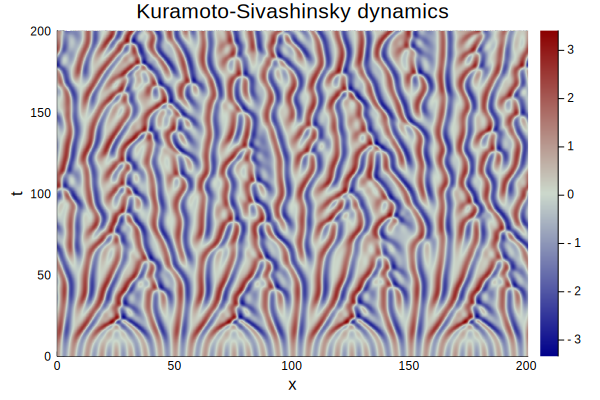

In [16]:
t,U = ksintegrateInplace(u, Lx, dt, Nt, nsave)
heatmap(x,t,U, xlim=(x[1], x[end]), ylim=(t[1], t[end]), xlabel="x", ylabel="t", 
title="Kuramoto-Sivashinsky dynamics", fillcolor=:bluesreds)

### Julia unrolled

The [Julia unrolled code](codes/ksintegrateUnrolled.jl) uses in-place FFTs and unrolls several time-stepping vector operations into for loops.

## Benchmark codes, all languages

Here are the benchmark codes, which include both the integration algorithm and a driver program to run and time the algorithm at a given $N_x$. I haven't bothered to automate the running of the benchmark codes or the production of the benchmark data files. I run them manually as follows, from within the ``codes`` directory. 

**Python:** [ksbenchmark.py](codes/ksbenchmark.py) From an interactive python shell run 

```
Python 2.7.13 (default, Mar 22 2017, 12:31:17) [GCC] 
IPython 3.2.2 -- An enhanced Interactive Python.
In [1]: execfile("ksbenchmark.py")

In [2]: ksbenchmark(512)
```

**Matlab:** [ksbenchmark.m](codes/ksbenchmark.m) From a Matlab prompt 

```
>> ksbenchmark(512)
```


**Julia:** [ksbenchmark.jl](codes/ksbenchmark.jl) At the Julia REPL run 

```
julia> include("ksbenchmark.jl")
julia> ksbenchmark(512, ksintegrateNaive)
```

etc. for ``ksintegrateInplace`` and ``ksintegrateUnrolled``. Or, better, use Julia's benchmarking tools, which compute a more reliable timing that the simple average-of-Nruns tic-toc approach used in my ``ksbenchmark`` function. 

```
julia> using BenchmarkTools
julia> @benchmark ksintegrateNaive(ksinitconds(512)...)
```

**C:** [ksbenchmark.c](codes/ksbenchmark.c) At Unix prompt 

```
bash$ clang -O3 -o ksbenchmark-c ksbenchmark.c -lfftw3 -lm
bash$ ksbenchmark-c 512
```

**C++:** [ksbenchmark.cpp](codes/ksbenchmark.cpp) At Unix prompt

```
bash$ clang -O3 -o ksbenchmark-c++ -lfftw3 -lm
bash$ ksbenchmark-c++ 512
```

**Fortran:** [ksbenchmark.f90](codes/ksbenchmark.f90) Edit the file to set $N_x$, then at Unix prompt

```
bash$ gfortran -O3 -o ksbenchmark-f90 -lfftw3
bash$ ksbenchmark-f90
```

Details about optimization flags and compiler, language, library versions are listed in the [cputime.asc](benchmark-data/cputime.asc) data file. 


## Room for improvement

  * Automate the build and benchmarking process
  * Implement more highly-tuned/sophisticated approaches
      * Numba and Dedalus codes for Python
      * ``DifferentialEquations.jl + ApproxFun.jl`` code for Julia
      * real-to-complex versions wherever possible
      * multithreaded versions
  * Analysis of the overhead costs.
  * Do something similar with a 2d or 3d PDE and distributed-memory computations. 


## Acknowledgements

Thanks to 

  * Mahtab Lak, University of New Hampshire Mathematics. Her Ph.D. Minor Project in Applied Math formed the basis for this work. 
  * Ashley Willis, University of Sheffield, wrote the Fortran 90 code. 
  * David Sanders, Universidad Nacional Autónoma de México, for encouraging me to put this notebook together.
  * Chris Rackauckas, University of California Irvine, for Julia performance tips.
  * Sheehan Olver, University of Sydney, and Chris Rackauckas, for Julia Discourse discussions on strategies for implementing HPC PDE codes in Julia. 
  * traktofon@github for fixing the Fortran code in numerous ways
  
John F. Gibson,
Dept. Mathematics and Statistics,
University of New Hampshire